In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
from scipy.spatial import distance

import geopandas as gp
from shapely.geometry import Point, LineString

import matplotlib.pyplot as plt

# Mapping Closest Location IDs
The objective is to map the closest location IDs for arrays of geospatially distributed points. 

We will be mapping the following data sets:
1. Bus Stop IDs to Traffic Count Sensor IDs
2. Traffic Count Sensor IDs to Neighborhood Names
3. Bus Stop IDs to Neighborhood Names

We will not be mapping Traffic Count Sensor IDs to the closest Bus Route. Bus Routes are already mapped to the Bus Stops they pass through.

In [2]:
# Locational Data Files
f_traffic_counts = '../Data/Traffic Counts /8edd8a76-8607-4ed3-960f-dcae914fd937.csv'
f_bus_stop = '../Data/Port Authority Transit Stop Usage/busstopusagebyroute.csv'
f_neighborhood_shp = '../Data/Pittsburgh SNAP Data 2010/Neighborhoods_with_SNAP_Data/Neighborhoods_with_SNAP_Data.shp'

# Define crs projections
crs = {'init': 'epsg:4326'} #Spherical Proj [=] degrees
crs_merc = {'proj': 'cea'} #Mercator Proj [=] m

In [3]:
def closest_node(node, nodes):
    """Given POINT geometry node, find the closest POINT geometry in array nodes."""
    closest_index = distance.cdist(np.array([node.x, node.y], ndmin=2), np.array([nodes.x, nodes.y]).T).argmin()
    return nodes[closest_index]

In [4]:
def closest_node_id(node, nodes):
    """Given POINT geometry node, find the closest POINT geometry in array nodes."""
    closest_index = distance.cdist(np.array([node.x, node.y], ndmin=2), np.array([nodes.x, nodes.y]).T).argmin()
    return closest_index

In [5]:
def within_poly_id(node, polygons):
    """Given POINT geometry node, find the POLYGON geometry it is within."""
    within_index = []
    for p in polygons:
        within_index.append(node.within(p))
    
    not_within = 0
    many_within = 0
    wi = np.nan

    if sum(within_index) < 1:
#         print('{} not within any POLYGONS'.format(node))
        not_within = 1
        
    elif sum(within_index) > 1:
#         print('{} within {} POLYGONS. Choosing first for index.'.format(node, sum(within_index)))
        many_within = 1
    else:
        wi = np.argwhere(within_index)
    return wi, not_within, many_within

In [6]:
def array_closest_node_id(df, df_geom_col, dfc, dfc_geom_col):
    """Given two dfs with POINTs and an array nc of df POINT and the closest POINT in dfc, 
    returns a df of IDs in df and IDs in dfc. Assumes all POINTs and their associated node ids are unique.
    Assumes the IDs of each df are the df indexes."""
    n_nc = []
    for n_i in df.index:
        nc_i = closest_node_id(df.loc[n_i,df_geom_col], dfc[dfc_geom_col])
        n_nc.append([n_i, df.loc[n_i, df_geom_col],
                     dfc.index[nc_i], dfc.loc[dfc.index[nc_i], dfc_geom_col]])
        
    result = pd.DataFrame(n_nc)
    result.rename(columns = {0: 'from_node', 1: 'geom_from_node',
                            2: 'to_node', 3: 'geom_to_node'}, inplace = True)
    return result

In [7]:
def nodes_within_polygons(df, df_geom_col, dfn, dfn_geom_col):
    """Given two dfs with POINTs and POLYGON shapes, identify which POLYGON each POINT is in
    return a df of IDs in df and IDs in dfn."""
    n_nin = []
    not_within = 0
    many_within = 0
    for n_i in df.index:
        nin_i, nw, mw = within_poly_id(df.loc[n_i,df_geom_col], dfn[dfn_geom_col])
        not_within += nw
        many_within += mw
        if np.isnan(nin_i):
            n_nin.append([n_i, df.loc[n_i, df_geom_col],
                         np.nan, np.nan])
        else:
            n_nin.append([n_i, df.loc[n_i, df_geom_col], 
                          dfn.index[nin_i[0][0]], dfn.loc[dfn.index[nin_i[0][0]], dfn_geom_col]])
            
    print("""
    Total nodes: {}\n
    Nodes not within any POLYGONS: {}\n
    Nodes within more than one POLYGON: {}
    """.format(len(df),not_within, many_within))
    
    result = pd.DataFrame(n_nin)
    result.rename(columns = {0: 'node', 1: 'geom_node',
                            2: 'polygon', 3: 'geom_polygon'}, inplace = True)
    return result

In [8]:
def line_from_nodes(df, crs):
    """Connects two nodes in given crs and returns geopandas df with column of LineStrings connecting nodes."""
    geom = df.apply(lambda x: LineString([x['geom_from_node'], x['geom_to_node']]), axis=1)
    return gp.GeoDataFrame(df, crs=crs, geometry=geom)

## Mapping Bus Stops to Traffic Sensors

In [9]:
traffic_counts_df = pd.read_csv(f_traffic_counts)

In [10]:
traffic_counts = gp.GeoDataFrame(traffic_counts_df, crs=crs,
                                 geometry=gp.points_from_xy(traffic_counts_df['Longitude'],
                                                            traffic_counts_df['Latitude']))
traffic_counts_merc = traffic_counts.copy().to_crs(crs_merc) #Convert to Mercator Proj; epsg:3857
traffic_counts_merc.set_index('sensor_ID', inplace = True)

In [11]:
bus_stop_df = pd.read_csv(f_bus_stop)

In [12]:
bus_stop = gp.GeoDataFrame(bus_stop_df, crs=crs,
                           geometry=gp.points_from_xy(bus_stop_df['LONGITUDE'],
                                                      bus_stop_df['LATITUDE']))
bus_stop_merc = bus_stop.copy().to_crs(crs_merc) #Convert to Mercator Proj; epsg:3857
bus_stop_merc_uniq = bus_stop_merc.copy().drop_duplicates('STOP_ID')
bus_stop_merc_uniq.set_index('STOP_ID', inplace = True)

In [13]:
bs_to_tc = array_closest_node_id(bus_stop_merc_uniq, 'geometry', traffic_counts_merc, 'geometry')

In [14]:
bs_to_tc.rename(columns = {'from_node':'STOP_ID', 'to_node':'sensor_ID'}, inplace = True) 

In [15]:
bs_to_tc_lines = line_from_nodes(bs_to_tc.copy(), crs_merc)
bs_to_tc_lines = bs_to_tc_lines.to_crs(crs)

In [25]:
bs_to_tc_lines.to_csv('bus_stops_to_traffic_count_sensors.csv')

In [24]:
bs_to_tc_lines.to_csv('bus_stops_to_traffic_count_sensors_clean.csv', sep=';', index=False, columns=['STOP_ID','sensor_ID','geometry'])

<IPython.core.display.Javascript object>


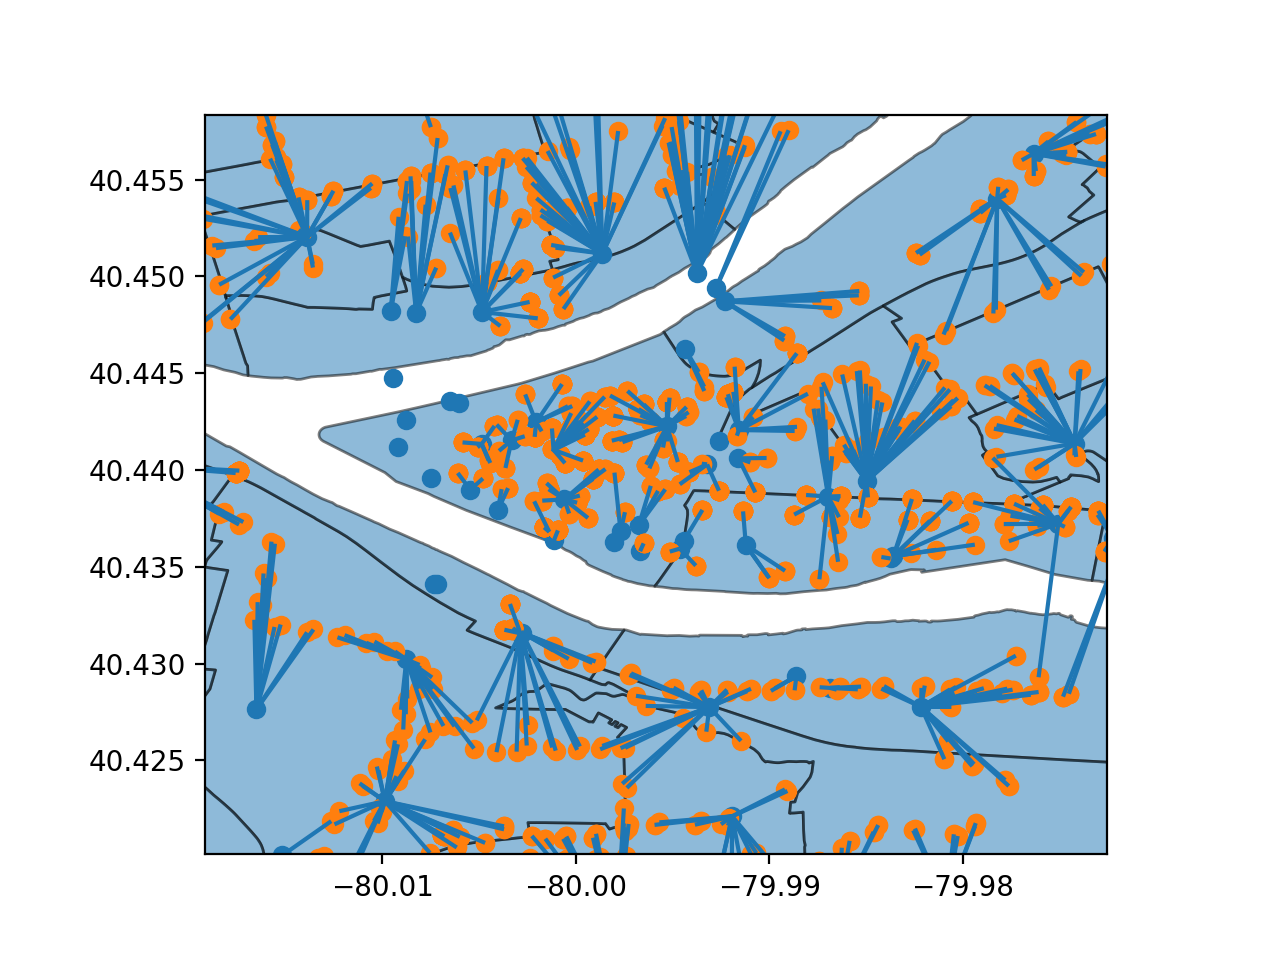

In [537]:
fig, ax = plt.subplots();
neighborhood_shp.plot(alpha=0.5, edgecolor='k',ax=ax);
traffic_counts.plot(ax=ax);
bus_stop.plot(ax=ax)
bs_to_tc_lines.plot(ax=ax)

## Mapping Traffic Sensors to Neighborhoods

In [26]:
neighborhood_shp = gp.read_file(f_neighborhood_shp)

In [27]:
neighborhood = neighborhood_shp.copy()
neighborhood.set_index('SNAP_All_c', inplace=True)

In [28]:
tc = traffic_counts.copy()
tc.set_index('sensor_ID', inplace=True)
tc_n = nodes_within_polygons(tc, 'geometry', neighborhood, 'geometry')


    Total nodes: 1305

    Nodes not within any POLYGONS: 1080

    Nodes within more than one POLYGON: 0
    


In [550]:
tc_n.to_csv('traffic_count_sensors_to_neighborhoods.csv')

In [34]:
tc_n[pd.notnull(tc_n['polygon'])].to_csv('traffic_count_sensors_to_neighborhoods_clean.csv',sep=';',index=False,columns=['node','polygon'])

## Mapping Bus Stops to Neighborhoods

In [35]:
bs = bus_stop_merc_uniq.copy()
bs = bs.to_crs(crs)
bs_n = nodes_within_polygons(bs, 'geometry', neighborhood, 'geometry')


    Total nodes: 6885

    Nodes not within any POLYGONS: 3993

    Nodes within more than one POLYGON: 0
    


In [569]:
bs_n.to_csv('bus_stops_to_neighborhoods.csv')

In [37]:
bs_n[pd.notnull(bs_n['polygon'])].to_csv('bus_stops_to_neighborhoods_clean.csv',sep=';',index=False,columns=['node','polygon'])

# Scratch Code

In [425]:
t_bs = traffic_counts_to_bus_stop.copy()
t_bs.set_index('STOP_ID', drop=False, inplace=True)
t_bs = pd.concat([t_bs, bus_stop_merc_uniq['geometry']], axis=1, join='inner')
t_bs.set_index('sensor_ID', drop=False, inplace=True)
t_bs.rename(columns = {'geometry':'geom_bus_stop'}, inplace=True)
t_bs_tc = pd.concat([t_bs, traffic_counts_merc['geometry']], axis=1, join='inner')
t_bs_tc.reset_index(inplace=True, drop=True)
t_bs_tc.rename(columns = {'geometry':'geom_sensor'}, inplace=True)